# Simulación Monte Carlo: Distribución de Rayleigh

#### Descripción

En este trabajo se estudia la duracción de un dispositivo constituido por $11$ componentes, que supondremos variables de *Rayleigh*, organizados en distintas configuraciones (serie, paralelo, stand-by, etc.). Para ello, utilizaremos el método de simulación *Monte Carlo*.

#### Contenidos

  * [Apartado A - Simulación](#Apartado-A)
    * [Apartado A.1 - Serie](#Apartado-A.1)
    * [Apartado A.2 - Paralelo](#Apartado-A.2)
    * [Apartado A.3 - Stand By](#Apartado-A.3)
    * [Apartado A.4 - "Al menos 6"](#Apartado-A.4)
    * [Apartado A.5 - Promedio](#Apartado-A.5)
  * [Apartado B - Aproximaciones Puntuales](#Apartado-B)
    * [Apartado B.1 - Serie](#Apartado-B.1)
    * [Apartado B.2 - Paralelo](#Apartado-B.2)
    * [Apartado B.3 - Stand By](#Apartado-B.3)
    * [Apartado B.4 - "Al menos 6"](#Apartado-B.4)
    * [Apartado B.5 - Promedio](#Apartado-B.5)
  * [Apartado C - Estudio Analítico](#Apartado-C)
    * [Apartado C.1 - Serie](#Apartado-C.1)
    * [Apartado C.2 - Paralelo](#Apartado-C.2)


#### Autor

  * Sergio García Prado - [garciparedes.me](https://garciparedes.me)
  

#### Fecha

  Mayo de 2018

In [1]:
rm(list = ls())

In [2]:
library(ggplot2)
library(gridExtra)
library(tidyr)
library(dplyr)
library(magrittr)


Attaching package: ‘dplyr’

The following object is masked from ‘package:gridExtra’:

    combine

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘magrittr’

The following object is masked from ‘package:tidyr’:

    extract



## Contexto

*Unos determinados componentes de hardware informático tienen una vida útil que se comporta según la distribución de Rayleigh, de parámetro $\sigma = 1$ año, según información fiable recibida del fabricante. La función de densidad del modelo de Rayleigh es sobradamente conocida por todos:* 

$$f(x) = \frac{x}{\sigma^2}exp\left(-\frac{x^2}{2\sigma^2}\right), \ x >0$$

*Se tiene un equipo informático en cuya fabricación se incorpora un dispositivo formado **$11$ componentes** de los anteriores, que pueden estar acoplados según diferentes esquemas según se indica má adelante. Se supone que el equipo informático está funcionando ininterrumpidamente desde su puesta en marcha y que, idealmente, solo son posibles los fallos de los componetes que se están estudiando.*

Uno de los primeros pasos antes de comenzar a realizar el ejercicio es el de definir la función de densidad de la distribución de Rayleigh, para poder trabajar con ella, así como estudiar su forma:

In [3]:
rayleigh.density <- function(x, sigma = 1) {
    x / sigma ^ 2 * exp(- x ^ 2 / (2 * sigma ^ 2))
}

Para la transformación cuantil, necesitaremos apoyarnos en la función de distribución de la variable aleatoria de estudio, la cual es fácil de obtener a partir de la función de densidad:

\begin{align}
F(x) &= \int_0^x f(t) \,dt \\
&= \int_0^x \frac{t}{\sigma^2}exp\left(-\frac{t^2}{2\sigma^2}\right) \,dt \\
&= \left(-exp\left(-\frac{t^2}{2\sigma^2}\right)\right]_0^x \\
&= 1 -exp\left(-\frac{x^2}{2\sigma^2}\right), \ x >0
\end{align}

In [4]:
rayleigh.distribution <- function(x, sigma = 1) {
    1 - exp(- x ^ 2 / (2 * sigma ^ 2))
}

Ahora, necesitamos invertir la función de distribución para poder utilizarla en la transformación cuantil, la cual utilizaremos para llevar a cabo la simulación Monte Carlo. A continuación se indican los pasos necesarios para la inversión de $F(x)$:

\begin{align}
y  &= 1 -exp \left( - \frac{x^2}{2 \sigma ^ 2}\right) \\
1 - y  &= exp \left(- \frac{x^2}{2 \sigma ^ 2}\right) \\
ln\left(1 - y \right) &= -\frac{x ^ 2}{2 \sigma ^ 2} \\
-2\sigma^2ln\left(1 - y \right)  &= x^2 \\
\sigma\sqrt{-2ln\left(1 - y \right)}  &= x
\end{align}

Una vez invertida, la transformación cuantil para la distribución de Rayleigh es la siguiente:

\begin{equation}
F^{-1}(x) = \sigma\sqrt{-2ln\left(1 - x \right)}, \ x \in [0, 1]
\end{equation}

In [5]:
rayleigh.quantile <- function(x, sigma = 1) {
    sigma * sqrt(- 2 * log(1 - x))
}

Para comprender mejor el comportamiento de esta distribución, es muy util representar gráficamente las funciones descritas superiormente:

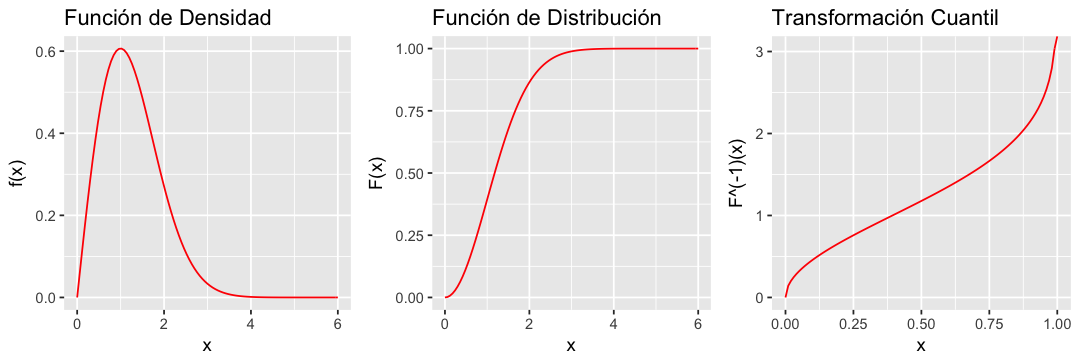

In [6]:
options(repr.plot.height = 3, repr.plot.width = 9)
grid.arrange(
    ggplot(data.frame(x=c(0, 6)), aes(x)) + 
        stat_function(fun = rayleigh.density, col = "red") +
        ylab("f(x)") + 
        ggtitle("Función de Densidad"), 
    ggplot(data.frame(x=c(0, 6)), aes(x)) + 
        stat_function(fun = rayleigh.distribution, col = "red") +
        ylab("F(x)") + 
        ggtitle("Función de Distribución"), 
    ggplot(data.frame(x=c(0, 1)), aes(x)) + 
        stat_function(fun = rayleigh.quantile, col = "red") +
        ylab("F^(-1)(x)") + 
        ggtitle("Transformación Cuantil"),
    ncol = 3)

Tal y como se puede apreciar en los gráficos, la Distribución de Rayleigh no es simétrica. Su forma recuerda a la de distribución de la $\chi^2$ con una cola más pesada hacía la derecha. En nuestro caso, se ha fijado el parámetro de posición $\sigma = 1$ por lo que la mayoría de masa de probabilidad se localiza en dicha zona del soporte. La función de distribución refleja lo que se ha indicado anteriormente, pero además deja ver claramente el nivel de asimetría de la variable, que recoge más del $85\%$ de probabilidad antes tomar el valor $2$ en el soporte. La transformación cuantil es la función inversa de la de densidad, por lo que "refleja" dicho comportamiento.

### Apartado A

El enunciado del apartado es:

*Realizar un experimento de simulación Montecarlo para tener una aproximación razonable del comportamiento de las variables que se describen a continuación.*

*En el trabajo hay que describir y justificar razonadamente todos los pasos que se dan en el experimento de simulación.
Se recomienda recordar lo estudiado acerca de la transformación cuantil y la simulación de variables aleatorias en el Capítulo 4 del material de *del Barrio & Gordaliza*.*

*Se recomienda simular entre $5000$ y $10000$ muestras y presentar sendos histogramas como aproximaciones empíricas al modelo probabilístico (función de densidad) de cada una de las variables indicadas en los cinco subapartados.*

La simulación *Monte Carlo* se basa en la generación de valores de una determinada variable aleatoria con distribución seguida mediante la función inversa de la función de distribución y la generación aleatoria de valores de manera uniforme en el intervalo $[0, 1]$.

La intuicción detrás de este procedimiento es la siguiente: Si "elegimos" al azar y de manera uniforme cuantiles de una determinada distribución $F$, entonces al final estaremos obteniendo realizaciones de dicha distribución.

Esto, se puede llevar a cabo de manera automática si se generan números aleatorios de una distribución $U \sim U(0, 1)$ y después se transforman mediante la función de distribución inversa (transformación cuantil) que se acaba de calcular. Entonces si aplicamos $X = F^{-1}(U)$ se puede demostrar desarrollando la función de densidad de la variable $X$, que habremos conseguido $X \sim F$.

Por tanto, esta será la intuicción que utilizaremos para realizar una simulación sobre variables de *Rayleigh*. En concreto, y siguiendo el enunciado propuesto diseñaremos el experimento de la siguiente manera:

Sea: 

$$U_i = \left(U_{i1}, ..., U_{ij}, ..., U_{i11}\right) \ v.a.i.i.d. \ | \ U_{ij} \sim U\left(0,1\right) \ \forall i \in \{1, ..., 7500\} $$

Nuestras variables aleatorias (en este caso vector por referirse a 11 componentes) de partida, entonces realizaremos la transformación cuantil sobre todas ellas de tal manera que:

\begin{align}
F^{-1}\left(U_i\right) &= \left(F^{-1}\left(U_{i1}\right), ..., F^{-1}\left(U_{ij}\right), ..., F^{-1}\left(U_{i11}\right)\right)\\
 &= \left(X_{i1}, ..., X_{ij}, ..., X_{i11}\right) \\
 &= X_i
\end{align}

Por lo que habremos llegado a nuestra simulación de variables de *Rayleigh* mediante la transformación cuantil de variables de una distribución *Uniforme* en el intervalo $[0,1]$ tal y como se indica a continuación:

$$X_i = \left(X_{i1}, ..., X_{ij}, ..., X_{i11}\right) \ v.a.i.i.d. \ | \ X_{ij} \sim F \ \forall i \in \{1, ..., 7500\}$$

Además, debido a la suposición de independencia entre variables, es posible generar todos los valores como una muestra aleatoria simple y después agruparlos en vectores de $11$ componentes. A continuación se incluye el código necesario para realizar dicha generación de variables con distribución *Uniforme* así como la tranformación cuantil:

In [7]:
n.s <- 7500
n.c <- 11
x.limits <- c(0, 6)

uniform.sample <- 
    matrix(runif(n.s * n.c, min = 0, max = 1), ncol = n.c, nrow = n.s) %>%
    as.data.frame() %>%
    set_colnames(sprintf("C%02d", 1:n.c))

rayleigh.sample <- 
    rayleigh.quantile(uniform.sample)

Los histogramas resultante de las variables con distribución $Uniforme$ sobre cada componente se puede visualizar a continuación:

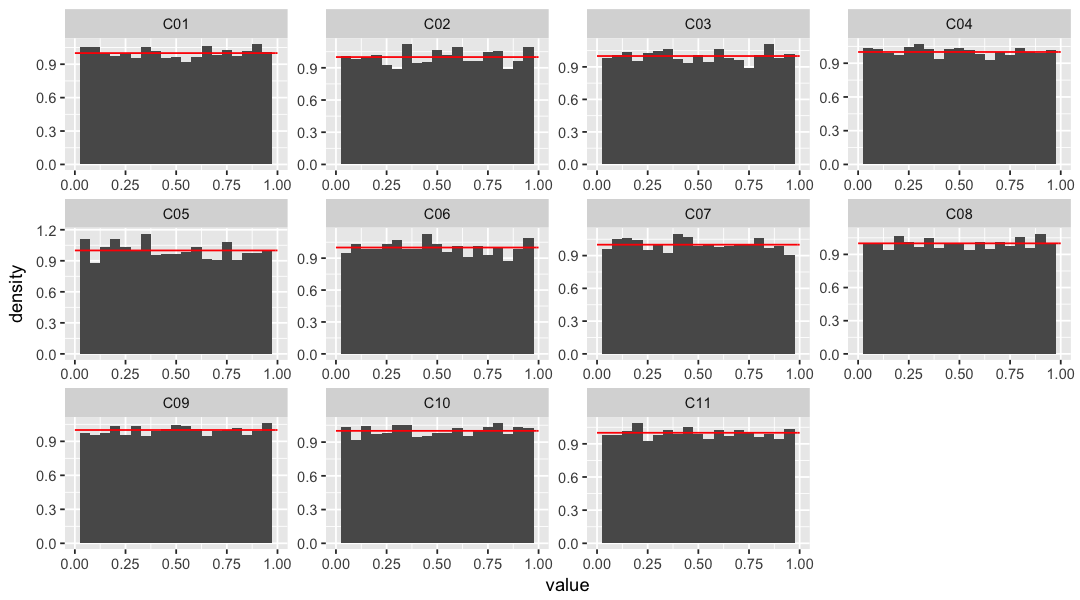

In [8]:
options(repr.plot.height = 5, repr.plot.width = 9)
uniform.sample %>%
    gather() %>% 
    ggplot(aes(value)) +
        scale_x_continuous(limits = c(0, 1)) + 
        geom_histogram(aes(y = ..density..), binwidth = 0.05) +
        stat_function(fun = dunif, col = "red") +
        facet_wrap(~ key, scales = "free")

Así como los histogramas de cada componente tras la realización de la transformación cuantil, resultando en simulaciones de la variables de $Rayleigh$:

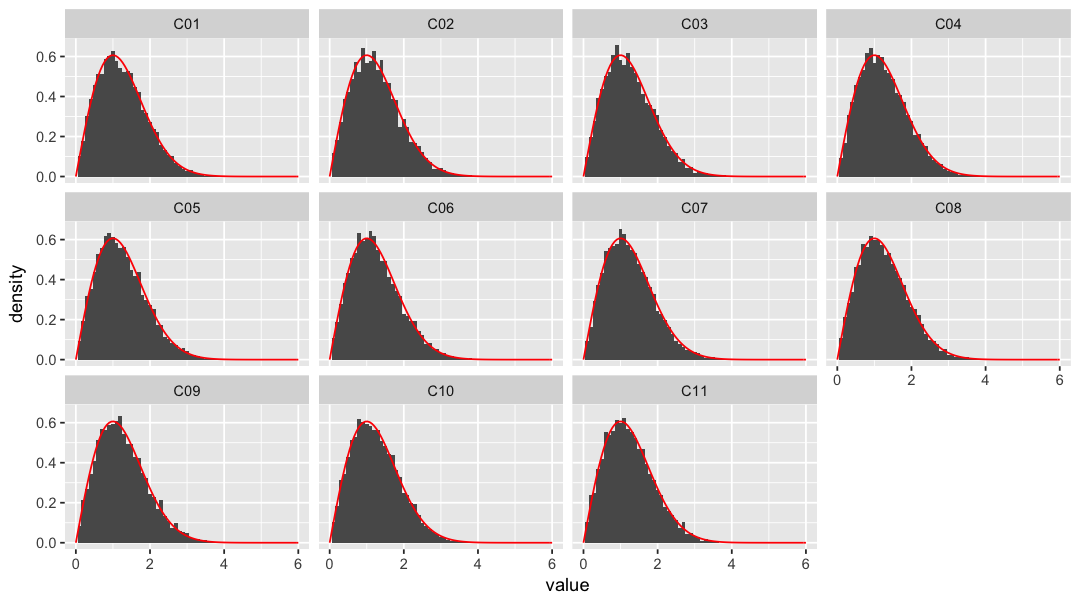

In [9]:
options(repr.plot.height = 5, repr.plot.width = 9)
rayleigh.sample %>%
    select(starts_with("C")) %>%
    gather() %>% 
    ggplot(aes(x = value)) +
        scale_x_continuous(limits = x.limits) + 
        geom_histogram(aes(y = ..density..), binwidth = 0.1) +
        stat_function(fun = rayleigh.density, col = "red") +
        facet_wrap(~ key)


Una vez generada la simulación resultante, se procederá a resolver las distintas cuestiones sobre distintas suposiciones sobre la forma en que se conectan los componentes del dispositivo. Para ello, el procedimiento que se seguirá es el siguiente: Primero se justificará el procedimiento utilizado para posteriormente realizar la pertinente transformación de los datos, que se representará de manera gráfica.

#### Apartado A.1

El enunciado del apartado es:

*La duración del dispositivo si los componentes están acoplados **en serie** (el dispositivo funciona mientras todos los componentes estén en funcionamiento).*

Como es obvio, diremos que la duracción de un dispositivo acoplado en serie es la del mínimo de los componentes que la componen. Por tanto, en cada observación de la muestra, seleccionaremos el mínimo de entre sus componentes.

In [10]:
rayleigh.sample$series <- 
    rayleigh.sample %>% 
    dplyr::select(dplyr::starts_with("C")) %>% 
    apply(1, min)

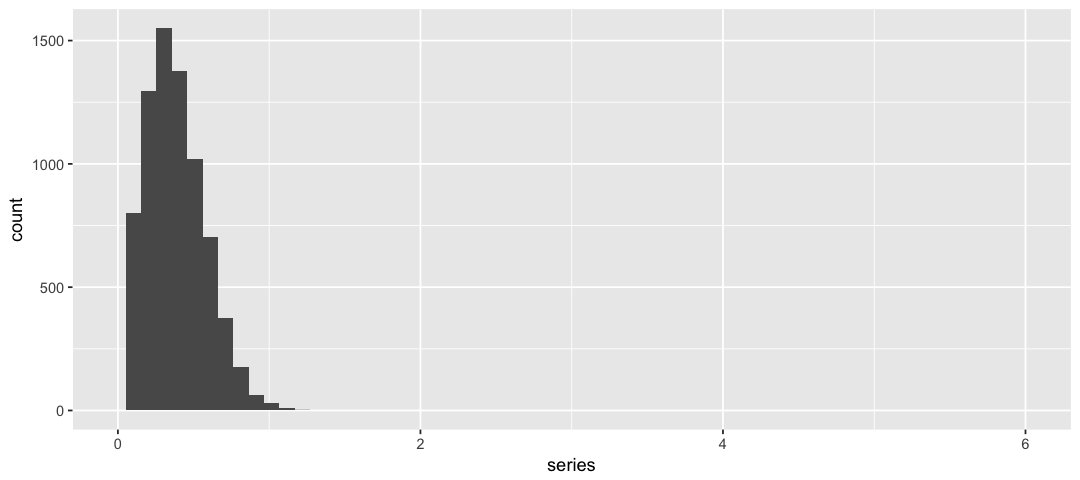

In [11]:
options(repr.plot.height = 4, repr.plot.width = 9)
rayleigh.sample %>%
    ggplot(aes(series)) +
    scale_x_continuous(limits = x.limits) + 
    geom_histogram(bins = 60)

En el [Apartado B.1](#Apartado-B.1) se calculan distintos estadísticos sobre la muestra generada.

#### Apartado A.2

El enunciado del apartado es:

*La duración del dispositivo si los componentes están acoplados **en paralelo** (el dispositivo funciona mientras alguno de los componentes estén funcionamiento)*

Como es obvio, diremos que la duracción de un dispositivo acoplado en paralelo es la del máximo de los componentes que la componen. Por tanto, en cada observación de la muestra, seleccionaremos el máximo de entre sus componentes.

In [12]:
rayleigh.sample$parallel <- 
    rayleigh.sample %>% 
    dplyr::select(dplyr::starts_with("C")) %>% 
    apply(1, max)

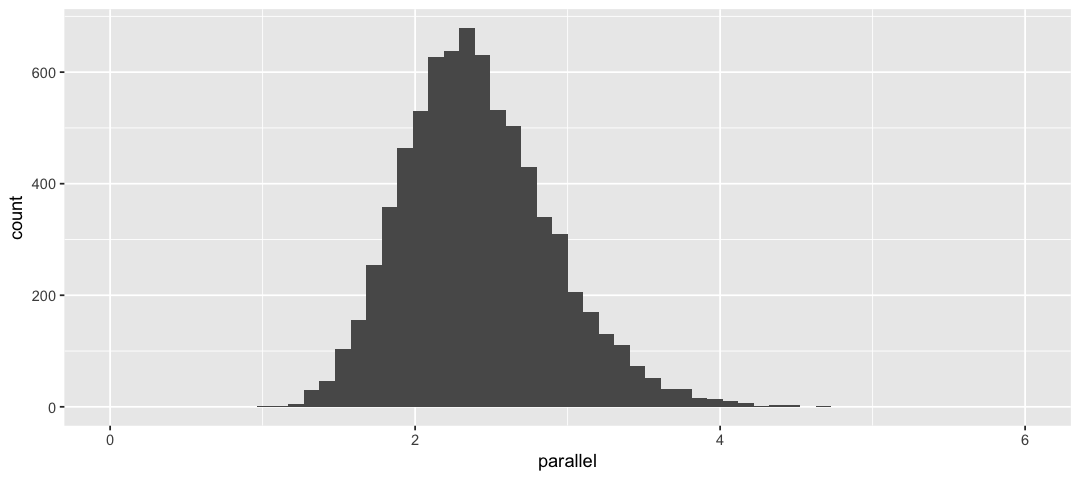

In [13]:
options(repr.plot.height = 4, repr.plot.width = 9)
rayleigh.sample %>%
    ggplot(aes(parallel)) +
    scale_x_continuous(limits = x.limits) + 
    geom_histogram(bins = 60)

En el [Apartado B.2](#Apartado-B.2) se calculan distintos estadísticos sobre la muestra generada.

#### Apartado A.3

El enunciado del apartado es:

*La duración del dispositivo si los componentes están **acoplados en "stand by"**, según se explica para esta modalidad de acoplamiento en el material de *del Barrio & Gordaliza* en el capítulo "Modelos de fiabilidad. La ley de Weibull."*

Como es obvio, diremos que la duracción de un dispositivo acoplado en "stand by" es la suma de las duraciones de cada componentes si entendemos que no puede funcionar ningún componente de manera simultanea y cuando uno de estos falla, comienza a funcionar otro de manera inmediata.Por tanto, en cada observación de la muestra, seleccionaremos la suma de sus componentes.

In [14]:
rayleigh.sample$stand.by <- 
    rayleigh.sample %>% 
    dplyr::select(dplyr::starts_with("C")) %>% 
    apply(1, sum)

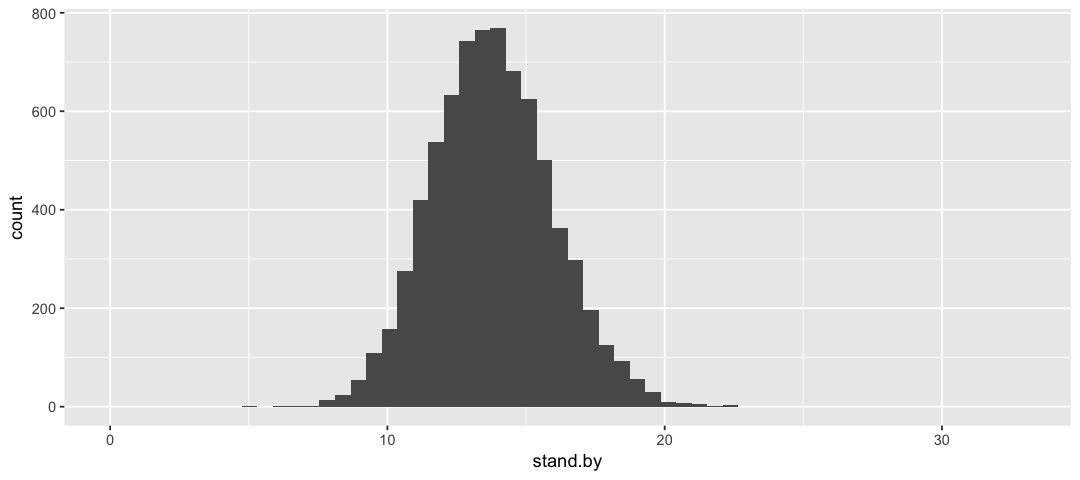

In [15]:
options(repr.plot.height = 4, repr.plot.width = 9)
rayleigh.sample %>%
    ggplot(aes(stand.by)) +
    scale_x_continuous(limits = x.limits * n.c / 2) + 
    geom_histogram(bins = 60)

En el [Apartado B.3](#Apartado-B.3) se calculan distintos estadísticos sobre la muestra generada.

#### Apartado A.4

El enunciado del apartado es:

*La duración del dispositivo si los componentes están acoplados de tal forma que **el dispositivo funciona mientras al menos seis de los componentes estén en funcionamiento**.*

Nótese que el caso de que funcionen al menos seis de los componentes es equivalente a preguntar por la mediana de los datos, por lo que nos encontramos en el promedo en sentido absoluto. Por tanto, en cada observación de la muestra, seleccionaremos la duración del componente situado en la quinta posición en la realización del estadístico ordenado para cada observación.

In [16]:
rayleigh.sample$least.6 <- 
    rayleigh.sample %>% 
    dplyr::select(dplyr::starts_with("C")) %>% 
    apply(1, sort) %>%
    {t(.)[, n.c - 6]}

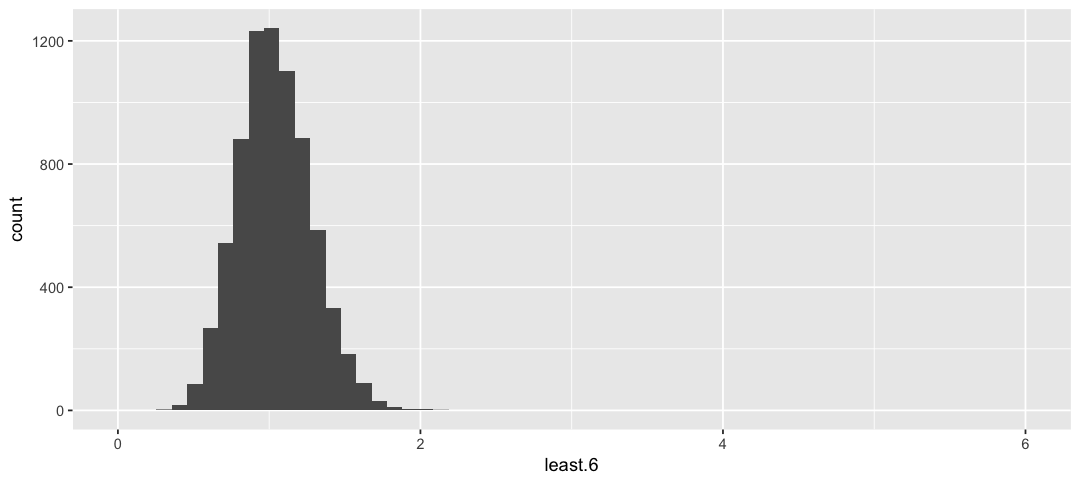

In [17]:
options(repr.plot.height = 4, repr.plot.width = 9)
rayleigh.sample %>%
    ggplot(aes(least.6)) +
    scale_x_continuous(limits = x.limits) + 
    geom_histogram(bins = 60)

En el [Apartado B.4](#Apartado-B.4) se calculan distintos estadísticos sobre la muestra generada.

#### Apartado A.5

El enunciado del apartado es:

*La **duración promedio de los once componentes** si se supone que todos comienzan su funcionamiento a la vez y el dispositivo se mantiene activo hasta que todos han fallado.*

En este caso se pide estudiar el promedio de la duración de cada componente. Por tanto, aplicaremos el promedio sobre cada observación de la muestra.

In [18]:
rayleigh.sample$mean <- 
    rayleigh.sample %>% 
    dplyr::select(dplyr::starts_with("C")) %>% 
    apply(1, mean)

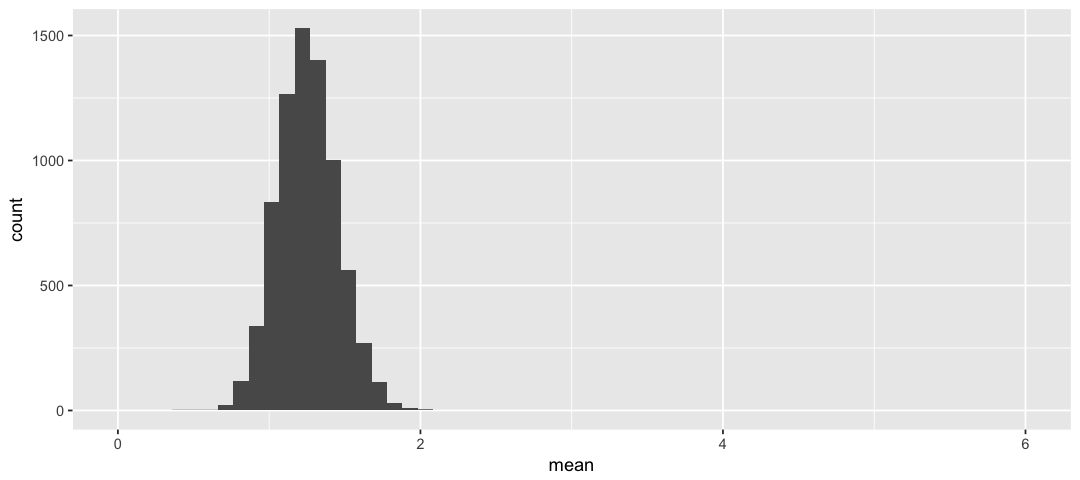

In [19]:
options(repr.plot.height = 4, repr.plot.width = 9)
rayleigh.sample %>%
    ggplot(aes(mean)) +
    scale_x_continuous(limits = x.limits) + 
    geom_histogram(bins = 60)

En el [Apartado B.5](#Apartado-B.5) se calculan distintos estadísticos sobre la muestra generada.

### Apartado B

El enunciado del apartado es:

*En todos los casos que se decriben en el apartado anterior, a partir de las simulaciones obtener una aproximación (estimación puntual) de los siguientes parámetros de la variable estudiaba: la media, la desviación típica, el percentil $2$ y la probabilidad de que la variable supere el valor $1.5$ añós.*

Para el cálculo los parámetros, se va a construir una función que simplifique la implementación en *R*:

In [20]:
ApproximateParameter <- function(x) {
    list(
        mean = mean(x),
        sd = sd(x),
        quantile.02 = quantile(x, 0.02, names = FALSE),
        p.upper.1.5 = sum(x > 1.5) / length(x)
    )
}

#### Apartado B.1

En este caso se utilizarán los datos transformados en el [Apartado A.1](#Apartado-A.1), y referidos a *La duración del dispositivo si los componentes están acoplados **en serie** (el dispositivo funciona mientras todos los componentes estén en funcionamiento).*

In [21]:
ApproximateParameter(rayleigh.sample$series)

$mean
[1] 0.3776803

$sd
[1] 0.1949673

$quantile.02
[1] 0.06216086

$p.upper.1.5
[1] 0

Estos valores son coherentes con el experimento que se pretende a estudiar, así como con la simulación realizada, estando la distribución muy próximos a  $0$ en el soporte, tanto que la probabilidad aproximada de que el dispositivo dure más de un año y medio se convierte en $0$

#### Apartado B.2

En este caso se utilizarán los datos transformados en el [Apartado A.2](#Apartado-A.2), y referidos a *La duración del dispositivo si los componentes están acoplados **en paralelo** (el dispositivo funciona mientras alguno de los componentes estén funcionamiento)*

In [22]:
ApproximateParameter(rayleigh.sample$parallel)

$mean
[1] 2.412269

$sd
[1] 0.4855957

$quantile.02
[1] 1.550053

$p.upper.1.5
[1] 0.9872

En el caso de la configuración en paralelo, la duración del dispositivo es mucho mayor, por ser necesario que todos los componentes fallen antes de que el dispositivo deje de funcionar. Además, en esta configuración la probabilidad de que el dispositivo dure más de un año y medio es alta.

#### Apartado B.3

En este caso se utilizarán los datos transformados en el [Apartado A.3](#Apartado-A.3), y referidos a *La duración del dispositivo si los componentes están **acoplados en "stand by"**, según se explica para esta modalidad de acoplamiento en el material de *del Barrio & Gordaliza* en el capítulo "Modelos de fiabilidad. La ley de Weibull."*

In [23]:
ApproximateParameter(rayleigh.sample$stand.by)

$mean
[1] 13.78375

$sd
[1] 2.166857

$quantile.02
[1] 9.529132

$p.upper.1.5
[1] 1

Para el caso de la configuración de componentes en modo "stand by", la duración del dispositivo es muy alta (como era de esperar), siendo mayor que 10 años con probabilidad alta (ya que el cuantil 0.02 se encuentra casi en dicho valor). Por estas razones, la probabilidad de que el dispositivo dure más de un año es técnicamente un suceso seguro.

#### Apartado B.4

En este caso se utilizarán los datos transformados en el [Apartado A.4](#Apartado-A.4), y referidos a *La duración del dispositivo si los componentes están acoplados de tal forma que **el dispositivo funciona mientras al menos seis de los componentes estén en funcionamiento**.*

In [24]:
ApproximateParameter(rayleigh.sample$least.6) 

$mean
[1] 1.038811

$sd
[1] 0.240637

$quantile.02
[1] 0.5866779

$p.upper.1.5
[1] 0.03466667

En esta configuración, nos encontramos en un punto intermedio entre el caso de los componentes conectados en serie y los sistemas conectados en paralelo, lo cual hace que se refleje en cierta manera en la los valores obtenidos. Nótese que el caso de que funcionen al menos seis de los componentes es equivalente a preguntar por la mediana de los datos, por lo que nos encontramos en el promedo en sentido absoluto.

#### Apartado B.5

En este caso se utilizarán los datos transformados en el [Apartado A.5](#Apartado-A.5), y referidos a *La **duración promedio de los once componentes** si se supone que todos comienzan su funcionamiento a la vez y el dispositivo se mantiene activo hasta que todos han fallado.*

In [25]:
ApproximateParameter(rayleigh.sample$mean)

$mean
[1] 1.253068

$sd
[1] 0.196987

$quantile.02
[1] 0.8662847

$p.upper.1.5
[1] 0.1098667

En este caso se está estudiando el tiempo promedio de los componentes, lo cual nos permite conocer más en detalle la duración de cada uno de ellos. Sin embargo, en este caso no nos podemos fijar en la desviación estándar de los datos, ya que está sesgada por el número de componentes promediados. Estudiando los valores de los parámetros sabemos que el tiempo promedio de duración de un componente es de un año y cuatro meses, así como que la decima parte de ellos no dura más de un año y medio.

### Apartado C

El enunciado del apartado es:

*Para los casos descritos en los apartados [A.1](#Apartado-A.1) y [A.2](#Apartado-A.2), obtener también una expresión analítica de la función de densidad de las variables siguiendo las indicaciones dadas en el material de *del Barrio & Gordaliza* en el capítulo "Modelos de fiabilidad. La ley de Weibull". Hacer una representación de dichas funciones superpuestas sobre los histogramas obtenidos por las simulaciones de Montecarlo.*

#### Apartado C.1

En este caso se va a estudiar el supuesto en el [Apartado A.1](#Apartado-A.1), el cual se refiere a la elección de una configuración en serie. Tal y como indicamos en dicho apartado, esto se refiere a la búsqueda del componente de menor duracción. Es decir,

Sea:
$$
X_1, ..., X_{n} \ v.a.i.i.d. \ | \ X_i \sim Rayleigh(\sigma)
$$

Entonces nuestra variable de estudio es: 

\begin{align}
X_S 
&= min\left(\left\{X_1, ..., X_{11}\right\}\right) \\
&= X_{(1)}
\end{align}

Como sabemos:

\begin{align}
F_S(x) 
&= F_{X_{(1)}}\left(x\right) \\
&= 1 - \left(1 - F_{X_i}\left(x\right) \right) ^ n \\
&= 1 - \left(1 - \left(1 -exp\left(-\frac{x^2}{2\sigma^2}\right)\right) \right) ^ n \\
&= 1 - exp\left(-\frac{nx^2}{2\sigma^2}\right)
\end{align}


\begin{align}
f_S(x) 
&= \frac{\partial}{\partial x} F_S(x) \\
&= \frac{\partial}{\partial x} 1 - exp\left(-\frac{nx^2}{2\sigma^2}\right) \\
&= \frac{nx}{\sigma^2} \cdot exp\left(-\frac{nx^2}{2\sigma^2}\right)
\end{align}

Si nos paramos a estudiar la relación entre esta variable y la de las variables de partida no es difícil darse cuenta de que:

$$
X_{S} \sim Rayleigh\left(\frac{\sigma}{\sqrt{n}}\right)
$$

Para nuestro caso en particular tenemos que:

$$
X_{S} \sim Rayleigh\left(\frac{1}{\sqrt{11}}\right)
$$

Por tanto, tan solo tendremos que cambiar el parámetro sigma por su valor adecuado.

A continuación se muestra una representación gráfica del histograma de la variable junto con la sobreposición de la función de densidad desarrollada de manera analítica en el párrafo anterior:

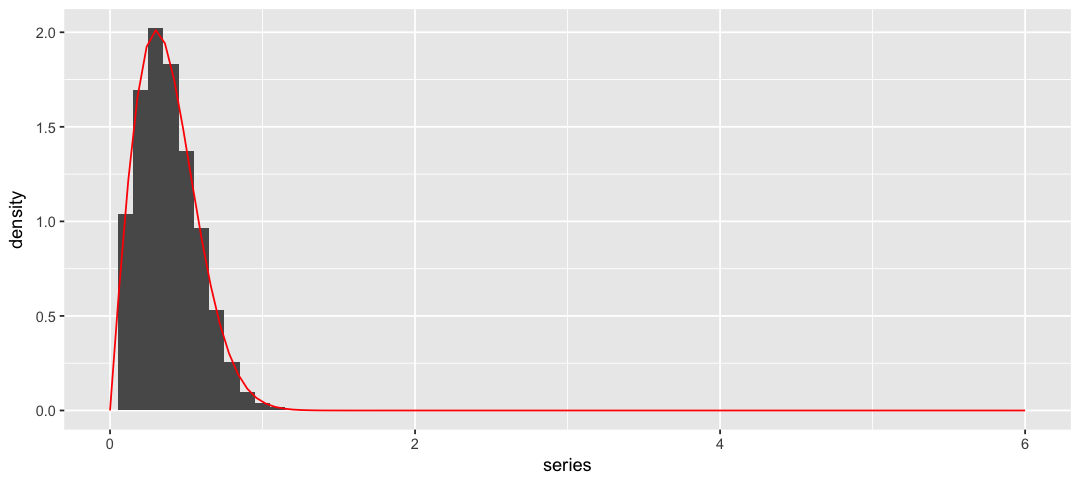

In [26]:
rayleigh.sample %>%
    ggplot(aes(x = series)) +
        scale_x_continuous(limits = x.limits) + 
        geom_histogram(aes(y = ..density..), binwidth = 0.1) +
        stat_function(fun = rayleigh.density, args = list(sigma = 1 / sqrt(n.c)), col = "red")

#### Apartado C.2

En este caso se va a estudiar el supuesto en el [Apartado A.1](#Apartado-A.1), el cual se refiere a la elección de una configuración en serie. Tal y como indicamos en dicho apartado, esto se refiere a la búsqueda del componente de menor duracción. Es decir,

Sea:
$$
X_1, ..., X_{n} \ v.a.i.i.d. \ | \ X_i \sim Rayleigh(\sigma)
$$

Entonces nuestra variable de estudio es: 

\begin{align}
X_P 
&= max\left(\left\{X_1, ..., X_{11}\right\}\right) \\
&= X_{(n)}
\end{align}

Como sabemos:

\begin{align}
F_P(x) 
&= F_{X_{(n)}}\left(x\right) \\
&= \left(F_{X_i}\left(x\right) \right) ^ n \\
&= \left(1 -exp\left(-\frac{x^2}{2\sigma^2}\right)\right) ^ n \\
\end{align}


\begin{align}
f_P(x) 
&= \frac{\partial}{\partial x} F_P(x) \\
&= \frac{\partial}{\partial x} \left(F_{X_i}\left(x\right) \right) ^ n \\
&= n \ f_{X_i}\left(x\right) \left(F_{X_i}\left(x\right) \right) ^ {n - 1}  \\
&= \frac{n x}{\sigma^2}exp\left(-\frac{x^2}{2\sigma^2}\right) \left(1 -exp\left(-\frac{x^2}{2\sigma^2}\right)\right) ^ {n - 1}
\end{align}

En este caso no parece surgir ninguna función conocida a partir de la transformación. A continuación se incluye el código *R* necesario para la implementación de la función:

In [27]:
rayleigh.max.density <- function(x, sigma = 1, n = 11) {
   n * rayleigh.density(x) * rayleigh.distribution(x) ^ (n - 1)
}

A continuación se muestra una representación gráfica del histograma de la variable junto con la sobreposición de la función de densidad desarrollada de manera analítica en el párrafo anterior:

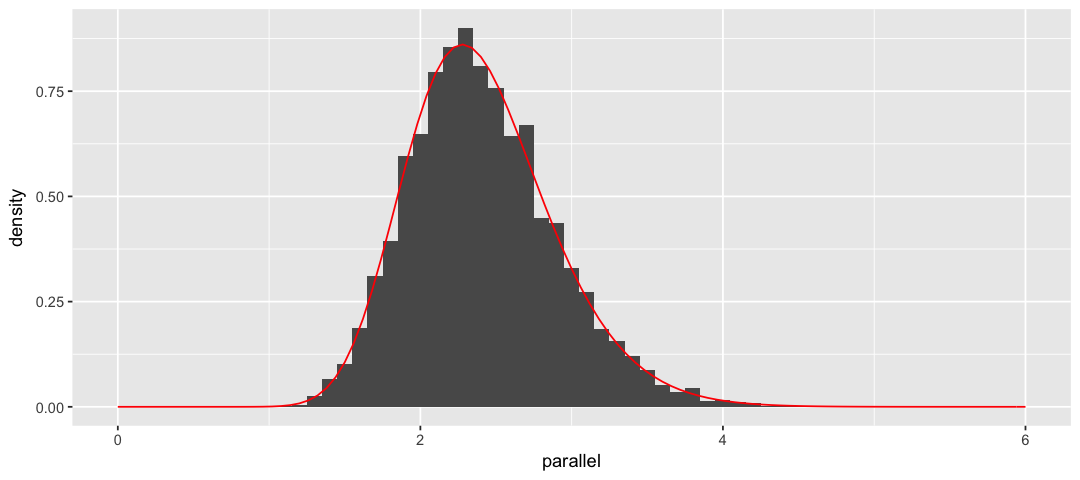

In [28]:
rayleigh.sample %>%
    ggplot(aes(x = parallel)) +
        scale_x_continuous(limits = x.limits) + 
        geom_histogram(aes(y = ..density..), binwidth = 0.1) +
        stat_function(fun = rayleigh.max.density, col = "red")